In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from refnx.dataset import Data1D
from refnx.analysis import Parameter, CurveFitter, Objective
from refnx.reflect import ReflectModel, SLD, Slab

from parabolic_brush import ParabolicBrush

In [2]:
# load the dataset
# data is simulated from https://doi.org/10.1103/PhysRevLett.73.3407, fig2 in toluene.
data = Data1D('karim_simulation.dat')

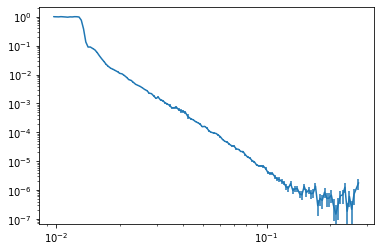

In [3]:
data.plot()
plt.yscale('log')
plt.xscale('log')

In [4]:
# create some SLD objects
# units are 10**-6 Å**-2
si = SLD(2.07)
sio2 = SLD(3.47)
dtol = SLD(5.6)
polymer = SLD(1.4)

In [5]:
# set up the brush Component. *A Component describes a subset of the interface*

# parameter to hold the adsorbed amount. This is equal to the area under the volume fraction
# profile for the dry brush. If you fit the dry data with a slab, this would be equal to the
# thickness multiplied by the polymer volume fraction of the dry film (close to 1?).
# Units Å
gamma = Parameter(95., 'adsorbed amount')

# roughness between brush and preceding layer (i.e. the SiO2).
# Units Å
lrough = Parameter(10., 'left roughness')

# same brush as that in Karim1994.
# the parameters for ParabolicBrush can be understood from the docstring for ParabolicBrush (see next cell)
brush = ParabolicBrush(polymer, 0.175, gamma, 1.0, 150, lrough, microslab_max_thickness=1)

In [6]:
help(ParabolicBrush)

Help on class ParabolicBrush in module parabolic_brush:

class ParabolicBrush(refnx.reflect.structure.Component)
 |  ParabolicBrush(polymer_sld, phi_0, gamma, alpha, delta, rough, name='', microslab_max_thickness=1)
 |  
 |  Component describing a parabolic brush (for neutron reflection). It
 |  should be the last Component before an infinite backing medium.
 |  
 |  Parameters
 |  ----------
 |  polymer_sld: SLD
 |      SLD of the brush
 |  phi_0: Parameter or float
 |      initial volume fraction of polymer
 |  gamma: Parameter or float
 |      Total interfacial volume of polymer
 |  alpha: Parameter or float
 |      exponent of parabolic profile
 |  delta: Parameter or float
 |      delta for smearing end of parabolic profile
 |  rough: Parameter or float
 |      Roughness between this Component and `left_component`
 |  name: str
 |      Name of component
 |  microslab_max_thickness : float, optional
 |      Thickness of microslicing of spline for reflectivity calculation
 |  
 |  N

In [7]:
# create a silicon dioxide slab, 15Å in thickness, with a 3 Å roughness between it
# and the preceding layer (towards the fronting medium). The slab can be made in two ways:
# using the SLD object
sio2_l = sio2(15, 3)
# or by making a Slab
sio2_l = Slab(15, sio2, 3)

# now we make a Structure by linking together Components. The structure encodes the entire
# interface.
# We start off with a silicon block, then finish off with a d-toluene slab that has
# 3 Å roughess between the dtoluene and the brush.
s = si | sio2_l | brush | dtol(0, 3)

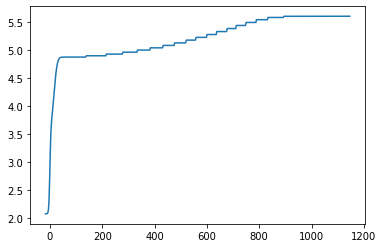

In [8]:
# let's plot the SLD profile
s.contract = 2
zed, sld = s.sld_profile()
plt.plot(zed, sld)

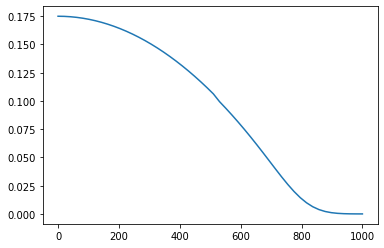

In [9]:
# plot the volume fraction profile
z = np.linspace(0, 1000)
vfp = brush.volume_fraction(z)
plt.plot(z, vfp)

In [10]:
# we then put the Structure into a ReflectModel that applies instrumental smearing, etc.
model = ReflectModel(s, bkg=5e-7, dq=4.97)

In [11]:
# the model is combined with a dataset into an Objective
objective = Objective(model, data)

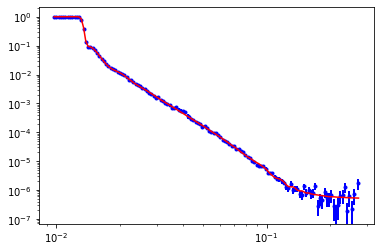

In [12]:
# Let's have a look at the fit. The fit looks good because we started off with the same parameters
# as we simulated the data with. Notice the small oscillation at the start.
objective.plot()
plt.yscale('log')
plt.xscale('log')

In [13]:
# let's fit the data anyway. To do that we have to specify which parameters we want to fit.

# this would be fitting the SLD of the d-toluene
dtol.real.setp(vary=True, bounds=(5.3, 5.4))

# silicon dioxide thickness
sio2_l.thick.setp(vary=True, bounds=(10, 20))

# adsorbed amount
gamma.setp(vary=True, bounds=(80, 120))

# phi_0, initial volume fraction of decay
brush.phi_0.setp(vary=True, bounds=(0.1, 0.3))

model.bkg.setp(vary=True, bounds=(1e-7, 1e-6))
model.scale.setp(vary=True, bounds=(0.95, 1.05))

In [14]:
objective.chisqr()

337.82854502776564

In [15]:
# not let's do a fit.
fitter = CurveFitter(objective)
fitter.fit("differential_evolution")

37it [06:15, 10.15s/it]


   covar: array([[ 1.77036694e-05,  2.77458453e-12,  2.17223818e-04,
         2.90977734e-06,  2.15601390e-03, -2.74242983e-06],
       [ 2.77458453e-12,  1.98089442e-15,  3.93387106e-09,
        -3.16250866e-12, -2.58497584e-09, -7.10362877e-13],
       [ 2.17223818e-04,  3.93387106e-09,  7.34851195e-02,
        -4.04116629e-05, -3.40750733e-02, -3.85058433e-05],
       [ 2.90977734e-06, -3.16250866e-12, -4.04116629e-05,
         1.59194828e-06,  1.25111921e-03,  3.54789939e-07],
       [ 2.15601390e-03, -2.58497584e-09, -3.40750733e-02,
         1.25111921e-03,  1.38371411e+00,  6.37360766e-04],
       [-2.74242983e-06, -7.10362877e-13, -3.85058433e-05,
         3.54789939e-07,  6.37360766e-04,  3.69908977e-06]])
     fun: 99.75531282146585
 message: 'Optimization terminated successfully.'
    nfev: 3903
     nit: 37
  stderr: array([4.20757287e-03, 4.45072401e-08, 2.71081389e-01, 1.26172433e-03,
       1.17631378e+00, 1.92330179e-03])
 success: True
       x: array([1.03813541e+00, 

In [16]:
# have a look at the ouput parameters and their uncertainties
print(objective)

________________________________________________________________________________
Objective - 140439794980944
Dataset = karim_simulation
datapoints = 135
chi2 = 2946.92842987229
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.03814 +/- 0.00421, bounds=[0.95, 1.05]>
<Parameter:     'bkg'     , value=4.92217e-07 +/- 4.45e-08, bounds=[1e-07, 1e-06]>
<Parameter:'dq - resolution', value=4.97 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , b